In [37]:
# ===============================================================
# 1) IMPORT LIBRARIES
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [38]:
# ===============================================================
# 1) LOAD DATASETS
# ===============================================================

from pathlib import Path
OUT = Path("../data")
print(OUT)

data = pd.read_csv(OUT / 'Cleaned_Features_for_ML.csv', index_col=0, parse_dates=True)

DATASET_LABEL = "Cleaned_Features_for_ML"   # or "Cleaned_Features_for_ML_20ANOVA"

..\data


In [39]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4085 entries, 2010-03-15 to 2025-11-26
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   S&P500                             4085 non-null   float64
 1   NASDAQ                             4085 non-null   float64
 2   DowJones                           4085 non-null   float64
 3   CAC40                              4085 non-null   float64
 4   DAX                                4085 non-null   float64
 5   FTSE100                            4085 non-null   float64
 6   Nikkei225                          4085 non-null   float64
 7   HangSeng                           4085 non-null   float64
 8   MSCIWorld                          4085 non-null   float64
 9   US10Y                              4085 non-null   float64
 10  US2Y                               4085 non-null   float64
 11  TLT                                408

In [40]:
print(data.tail(10))

              S&P500    NASDAQ  DowJones     CAC40       DAX   FTSE100  \
Date                                                                     
2025-11-13 -1.800835 -2.012372 -1.911938 -0.116626 -1.286203 -1.206402   
2025-11-14 -0.103218  0.060807 -0.783549 -0.700174 -0.652426 -1.283454   
2025-11-17 -1.018955 -0.771737 -1.380607 -0.581197 -1.110661 -0.291682   
2025-11-18 -0.923176 -1.089503 -1.254317 -1.687635 -1.594544 -1.461936   
2025-11-19  0.346751  0.448883  0.067861 -0.180675 -0.105241 -0.554962   
2025-11-20 -1.696201 -1.896199 -0.992297  0.285718  0.411328  0.217805   
2025-11-21  0.988488  0.703647  1.168726 -0.003846 -0.756935  0.118809   
2025-11-24  1.585285  2.248886  0.447614 -0.279299  0.534485 -0.080458   
2025-11-25  0.907986  0.522320  1.565905  0.722240  0.832171  0.860920   
2025-11-26  0.680125  0.650499  0.706248  0.766315  0.961830  0.942057   

            Nikkei225  HangSeng  MSCIWorld     US10Y  ...  \
Date                                              

In [41]:
# ===============================================================
#  SAVE RESULTS HELPERS (JSON + CSV EXPORT)
# ===============================================================
from pathlib import Path
import json
import numpy as np
import pandas as pd

# ===============================================================
# Define output folder inside project: /data
# ===============================================================

OUT = Path("../data")   # <-- for notebooks located inside /notebooks/
OUT.mkdir(parents=True, exist_ok=True)

def make_json_serializable(obj):
    """
    Recursively convert objects (numpy arrays, numpy numbers, dicts, lists)
    into JSON-serializable Python native types.
    """
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(i) for i in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    else:
        return obj

# ===============================================================
# JSON + CSV Saving Utilities
# ===============================================================

def save_results_to_json(results_dict, filename="model_results.json"):
    """Save the entire results dictionary into /data as JSON."""
    results_serializable = make_json_serializable(results_dict)
    filepath = OUT / filename

    with open(filepath, "w") as f:
        json.dump(results_serializable, f, indent=4)

    print(f"[INFO] Saved JSON to: {filepath.resolve()}")


def save_results_to_csv(results_dict, filename="model_results.csv"):
    """Flatten model metrics into tabular CSV saved under /data."""
    rows = []

    for model_name, res in results_dict.items():
        cm = np.array(res.get("confusion_matrix"))
        cr = res.get("classification_report", {})
        roc_auc = res.get("roc_auc", None)
        f2 = res.get("f2_score", None)
        comp_time = res.get("computation_time_sec", None)

        # Accuracy
        acc = cr.get("accuracy", None)

        # Positive class key
        pos_key = "1" if "1" in cr else None
        if not pos_key:
            keys = [k for k in cr.keys() if k.isdigit()]
            if keys:
                pos_key = keys[-1]

        precision_1 = recall_1 = f1_1 = None
        if pos_key and isinstance(cr.get(pos_key), dict):
            precision_1 = cr[pos_key].get("precision")
            recall_1 = cr[pos_key].get("recall")
            f1_1 = cr[pos_key].get("f1-score")

        # Confusion matrix extract
        tn = fp = fn = tp = None
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()

        rows.append({
            "Dataset": res.get("dataset_label", "Unknown"),   # <--- added
            "Model": model_name,
            "Accuracy": acc,
            "Precision (class 1)": precision_1,
            "Recall (class 1)": recall_1,
            "F1-score (class 1)": f1_1,
            "F2-score": f2,
            "ROC-AUC": roc_auc,
            "Computation Time (sec)": comp_time,
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "TP": tp,
        })

    df = pd.DataFrame(rows)

    filepath = OUT / filename
    df.to_csv(filepath, index=False)

    print(f"[INFO] Saved CSV to: {filepath.resolve()}")


# GLOBAL CONTAINER
results = {}

In [42]:
def save_results(model_name, y_true, y_pred, y_prob=None, comp_time=None):
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, fbeta_score

    # Create entry
    results[model_name] = {}

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    results[model_name]["confusion_matrix"] = cm

    # Classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    results[model_name]["classification_report"] = report

    # ROC-AUC
    if y_prob is not None:
        results[model_name]["roc_auc"] = roc_auc_score(y_true, y_prob)

    # F2-score
    results[model_name]["f2_score"] = fbeta_score(y_true, y_pred, beta=2)

    # Computation time
    results[model_name]["computation_time_sec"] = comp_time

    print(f"✓ Saved model results for: {model_name}")

In [43]:
# ===============================================================
# BINARY CLASSIFICATION – K-FOLD EVALUATION (FULL PIPELINE)
# ===============================================================

# ---------------------------------------------------------------
# 1) IMPORTS
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier,
    RandomForestClassifier, ExtraTreesClassifier
)

# ===============================================================
# 2) TRAIN / TEST SPLIT
# ===============================================================
features = data.drop(columns=['Apple', 'Return', 'Direction'])
target = data["Direction"] 

# Handle infinities and missing values early
features.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, shuffle=False
)
print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")

# ===============================================================
# 3) FEATURE TYPES
# ===============================================================
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

print(f"Numeric features: {len(numeric_features)} | Categorical features: {len(categorical_features)}")

# ===============================================================
# 4) PREPROCESSING PIPELINES
# ===============================================================
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# ===============================================================
# 5) DEFINE MODELS
# ===============================================================
models = [
    ('LR',  LogisticRegression(max_iter=5000, random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('CART', DecisionTreeClassifier(max_depth=6, random_state=42)),
    ('SVC', SVC(kernel='rbf', probability=True, random_state=42)),
    ('MLP', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=5000, random_state=42)),
    # Boosting
    ('ABR', AdaBoostClassifier(n_estimators=300, random_state=42)),
    ('GBR', GradientBoostingClassifier(n_estimators=300, random_state=42)),
    # Bagging
    ('RFR', RandomForestClassifier(n_estimators=300, random_state=42)),
    ('ETR', ExtraTreesClassifier(n_estimators=300, random_state=42))
]

# ===============================================================
# BINARY CLASSIFICATION — MODEL EVALUATION (Production Format)
# Output Table = [Model | Accuracy | F1 | AUC | F2 | Time]
# ===============================================================

from time import time
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, fbeta_score
)

results = {}    # global container for JSON/CSV export
rows_for_display = []   # container for final table display

print("\n====================================================")
print(" RUNNING MODELS — CLEAN OUTPUT TABLE FORMAT ")
print("====================================================\n")

for name, model in models:

    print(f"\n▶ Training {name} ...")

    # Build final pipeline
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", model)
    ])

    # ---- Start Timer ----
    t0 = time()

    # Fit model
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Probabilities for AUC
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
    else:
        y_prob = np.zeros_like(y_pred)

    # ---- Compute Metrics ----
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    f2  = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_prob)
    comp_time = time() - t0

    # Confusion matrix + full report
    cm     = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # ---- Save to global results dict (for Streamlit + JSON/CSV) ----
    results[name] = {
        "dataset_label": DATASET_LABEL,     # <--- added
        "test_accuracy": float(acc),
        "roc_auc": float(auc),
        "f1_score": float(f1),
        "f2_score": float(f2),
        "computation_time_sec": float(comp_time),
        "confusion_matrix": cm.tolist(),
        "classification_report": report
    }

    # ---- Save row for final output table ----
    rows_for_display.append([
        name, acc, f1, auc, f2, comp_time
    ])

    print(f"   ACC={acc:.4f} | F1={f1:.4f} | AUC={auc:.4f} | F2={f2:.4f} | Time={comp_time:.2f} sec")


# ===============================================================
# FINAL SUMMARY TABLE (Matches your screenshot format!)
# ===============================================================

df_results = pd.DataFrame(
    rows_for_display,
    columns=["Model", "Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"]
)

# Sort by AUC descending (or F1 if you prefer)
df_results = df_results.sort_values("AUC", ascending=False).reset_index(drop=True)

display(df_results.style.background_gradient(cmap="Blues"))


Train shape: (3268, 41) | Test shape: (817, 41)
Numeric features: 41 | Categorical features: 0

 RUNNING MODELS — CLEAN OUTPUT TABLE FORMAT 


▶ Training LR ...
   ACC=0.5239 | F1=0.6480 | AUC=0.5138 | F2=0.7502 | Time=0.76 sec

▶ Training KNN ...
   ACC=0.4957 | F1=0.5275 | AUC=0.5051 | F2=0.5341 | Time=0.57 sec

▶ Training CART ...
   ACC=0.5116 | F1=0.5440 | AUC=0.5215 | F2=0.5519 | Time=0.14 sec

▶ Training SVC ...
   ACC=0.5226 | F1=0.6865 | AUC=0.4947 | F2=0.8455 | Time=3.84 sec

▶ Training MLP ...
   ACC=0.5251 | F1=0.3822 | AUC=0.5283 | F2=0.3143 | Time=5.35 sec

▶ Training ABR ...
   ACC=0.5092 | F1=0.6705 | AUC=0.5004 | F2=0.8167 | Time=3.52 sec

▶ Training GBR ...
   ACC=0.5251 | F1=0.6566 | AUC=0.5044 | F2=0.7694 | Time=8.65 sec

▶ Training RFR ...
   ACC=0.4823 | F1=0.4934 | AUC=0.4829 | F2=0.4868 | Time=4.32 sec

▶ Training ETR ...
   ACC=0.5104 | F1=0.5690 | AUC=0.5035 | F2=0.5976 | Time=1.56 sec


,Model,Accuracy,F1-score,AUC,F2-score,Time (sec)
0,MLP,0.525092,0.382166,0.528283,0.314301,5.351576
1,CART,0.511628,0.544000,0.521531,0.551948,0.136984
2,LR,0.523868,0.647964,0.513817,0.750210,0.757610
3,KNN,0.495716,0.527523,0.505140,0.534138,0.569437
4,GBR,0.525092,0.656637,0.504408,0.769390,8.651191
5,ETR,0.510404,0.568966,0.503483,0.597555,1.561216
6,ABR,0.509180,0.670501,0.500426,0.816653,3.523704
7,SVC,0.522644,0.686495,0.494701,0.845545,3.844646
8,RFR,0.482252,0.493413,0.482877,0.486767,4.317889


In [44]:
save_results_to_json(results, "model_results.json")
save_results_to_csv(results, "model_results.csv")
print("✓ All results exported successfully.")

[INFO] Saved JSON to: C:\Users\dax_a\Documents\GitHub\ESILV-MLproject-AU-BEJOT\data\model_results.json
[INFO] Saved CSV to: C:\Users\dax_a\Documents\GitHub\ESILV-MLproject-AU-BEJOT\data\model_results.csv
✓ All results exported successfully.


In [45]:
# ===============================================================
# ADVANCED MODELS – ENSEMBLE & META-LEARNING COMPARISON
# ===============================================================
print("\n====================================================")
print("   ADVANCED ML MODELS – ENSEMBLE & STACKING")
print("====================================================\n")

import time
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    fbeta_score,
    confusion_matrix,
    classification_report
)

# ===============================================================
# 1) PREPROCESSING PIPELINE
# ===============================================================
def make_pipeline(model):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

# Base models
base_svm = SVC(kernel='rbf', probability=True, random_state=0)
base_dt  = DecisionTreeClassifier(random_state=0)


# ===============================================================
# 2) TUNED MODELS WITH GRID SEARCH
# ===============================================================

# --- SVM ---
param_svm = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", 0.01, 0.001]
}

tuned_svm = GridSearchCV(
    make_pipeline(SVC(probability=True, random_state=0)),
    param_svm,
    cv=5,
    n_jobs=-1,
    error_score="raise"
)
tuned_svm.fit(X_train, y_train)

# --- Decision Tree ---
param_dt = {
    "model__max_depth": [3, 5, 7, None],
    "model__min_samples_split": [2, 5, 10]
}

tuned_dt = GridSearchCV(
    make_pipeline(DecisionTreeClassifier(random_state=0)),
    param_dt,
    cv=5,
    n_jobs=-1,
    error_score="raise"
)
tuned_dt.fit(X_train, y_train)


# ===============================================================
# 3) BAGGING MODELS
# ===============================================================

bagging_svm = make_pipeline(
    BaggingClassifier(
        estimator=SVC(kernel='rbf', probability=True),
        n_estimators=20,
        max_samples=0.8,
        random_state=0
    )
)

bagging_dt = make_pipeline(
    BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=50,
        max_samples=0.8,
        random_state=0
    )
)


# ===============================================================
# 4) VOTING CLASSIFIER
# ===============================================================
voting = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", VotingClassifier(
        estimators=[
            ('svm', SVC(kernel='rbf', probability=True)),
            ('dt', DecisionTreeClassifier())
        ],
        voting='soft'
    ))
])


# ===============================================================
# 5) STACKING CLASSIFIER
# ===============================================================
stacking = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", StackingClassifier(
        estimators=[
            ('svm', SVC(kernel='rbf', probability=True)),
            ('dt', DecisionTreeClassifier()),
            ('bag_svm', BaggingClassifier(
                estimator=SVC(kernel='rbf', probability=True),
                n_estimators=10)),
            ('bag_dt', BaggingClassifier(
                estimator=DecisionTreeClassifier(),
                n_estimators=10))
        ],
        final_estimator=LogisticRegression(max_iter=500),
        passthrough=True,
        n_jobs=-1
    ))
])


# ===============================================================
# 6) MODEL COLLECTION
# ===============================================================
ensemble_models = {
    "Tuned SVM": tuned_svm.best_estimator_,
    "Tuned Decision Tree": tuned_dt.best_estimator_,
    "Bagging SVM": bagging_svm,
    "Bagging Decision Tree": bagging_dt,
    "Voting (SVM + DT)": voting,
    "Stacking Meta-Model": stacking
}


# ===============================================================
# 7) MASTER LOOP — TRAIN + EVALUATE + LOG INTO RESULTS
# ===============================================================
for name, model in ensemble_models.items():

    print(f"\n▶ Training {name} ...")
    start_time = time.time()

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = np.zeros_like(y_pred)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    f2  = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_prob)

    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    comp_time = time.time() - start_time

    # SAVE to global results dict — identical to your classic models structure
    results[name] = {
        "dataset_label": DATASET_LABEL,     # <--- added
        "train_accuracy": None,       # optional for ensembles
        "test_accuracy": float(acc),
        "roc_auc": float(auc),
        "f1_score": float(f1),
        "f2_score": float(f2),
        "computation_time_sec": float(comp_time),
        "confusion_matrix": cm.tolist(),
        "classification_report": report
    }

    print(f"""
{name}:
  ACC  = {acc:.4f}
  F1   = {f1:.4f}
  F2   = {f2:.4f}
  AUC  = {auc:.4f}
  Time = {comp_time:.2f} sec
""")


# ===============================================================
# 8) SUMMARY TABLE FOR DISPLAY — Ranked & Colored (as screenshot)
# ===============================================================

df_results_ens = pd.DataFrame([
    [
        name,
        results[name]["test_accuracy"],
        results[name]["f1_score"],
        results[name]["roc_auc"],
        results[name]["f2_score"],
        results[name]["computation_time_sec"]
    ]
    for name in ensemble_models.keys()
], columns=["Model", "Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"])

# ---- SORT by AUC (or switch to F1-score if preferred) ----
df_results_ens = df_results_ens.sort_values(by="AUC", ascending=False).reset_index(drop=True)

# ---- DISPLAY WITH BLUE GRADIENT BACKGROUND ----
display(
    df_results_ens.style.background_gradient(
        cmap="Blues",
        subset=["Accuracy", "F1-score", "AUC", "F2-score", "Time (sec)"]
    )
)


   ADVANCED ML MODELS – ENSEMBLE & STACKING


▶ Training Tuned SVM ...

Tuned SVM:
  ACC  = 0.5226
  F1   = 0.6865
  F2   = 0.8455
  AUC  = 0.5042
  Time = 3.44 sec


▶ Training Tuned Decision Tree ...

Tuned Decision Tree:
  ACC  = 0.4982
  F1   = 0.5747
  F2   = 0.6169
  AUC  = 0.5121
  Time = 0.06 sec


▶ Training Bagging SVM ...

Bagging SVM:
  ACC  = 0.5226
  F1   = 0.6865
  F2   = 0.8455
  AUC  = 0.4974
  Time = 20.37 sec


▶ Training Bagging Decision Tree ...

Bagging Decision Tree:
  ACC  = 0.4737
  F1   = 0.4953
  F2   = 0.4946
  AUC  = 0.4819
  Time = 3.65 sec


▶ Training Voting (SVM + DT) ...

Voting (SVM + DT):
  ACC  = 0.5006
  F1   = 0.5072
  F2   = 0.4979
  AUC  = 0.4930
  Time = 3.28 sec


▶ Training Stacking Meta-Model ...

Stacking Meta-Model:
  ACC  = 0.5165
  F1   = 0.6191
  F2   = 0.6924
  AUC  = 0.5063
  Time = 24.16 sec



,Model,Accuracy,F1-score,AUC,F2-score,Time (sec)
0,Tuned Decision Tree,0.498164,0.574689,0.512088,0.616927,0.063099
1,Stacking Meta-Model,0.516524,0.619094,0.506269,0.692407,24.156258
2,Tuned SVM,0.522644,0.686495,0.504239,0.845545,3.443640
3,Bagging SVM,0.522644,0.686495,0.497406,0.845545,20.370838
4,Voting (SVM + DT),0.500612,0.507246,0.493040,0.497866,3.280744
5,Bagging Decision Tree,0.473684,0.495305,0.481892,0.494609,3.650343


In [46]:
save_results_to_json(results, "model_results.json")
save_results_to_csv(results, "model_results.csv")
print("✓ All results exported successfully.")

[INFO] Saved JSON to: C:\Users\dax_a\Documents\GitHub\ESILV-MLproject-AU-BEJOT\data\model_results.json
[INFO] Saved CSV to: C:\Users\dax_a\Documents\GitHub\ESILV-MLproject-AU-BEJOT\data\model_results.csv
✓ All results exported successfully.


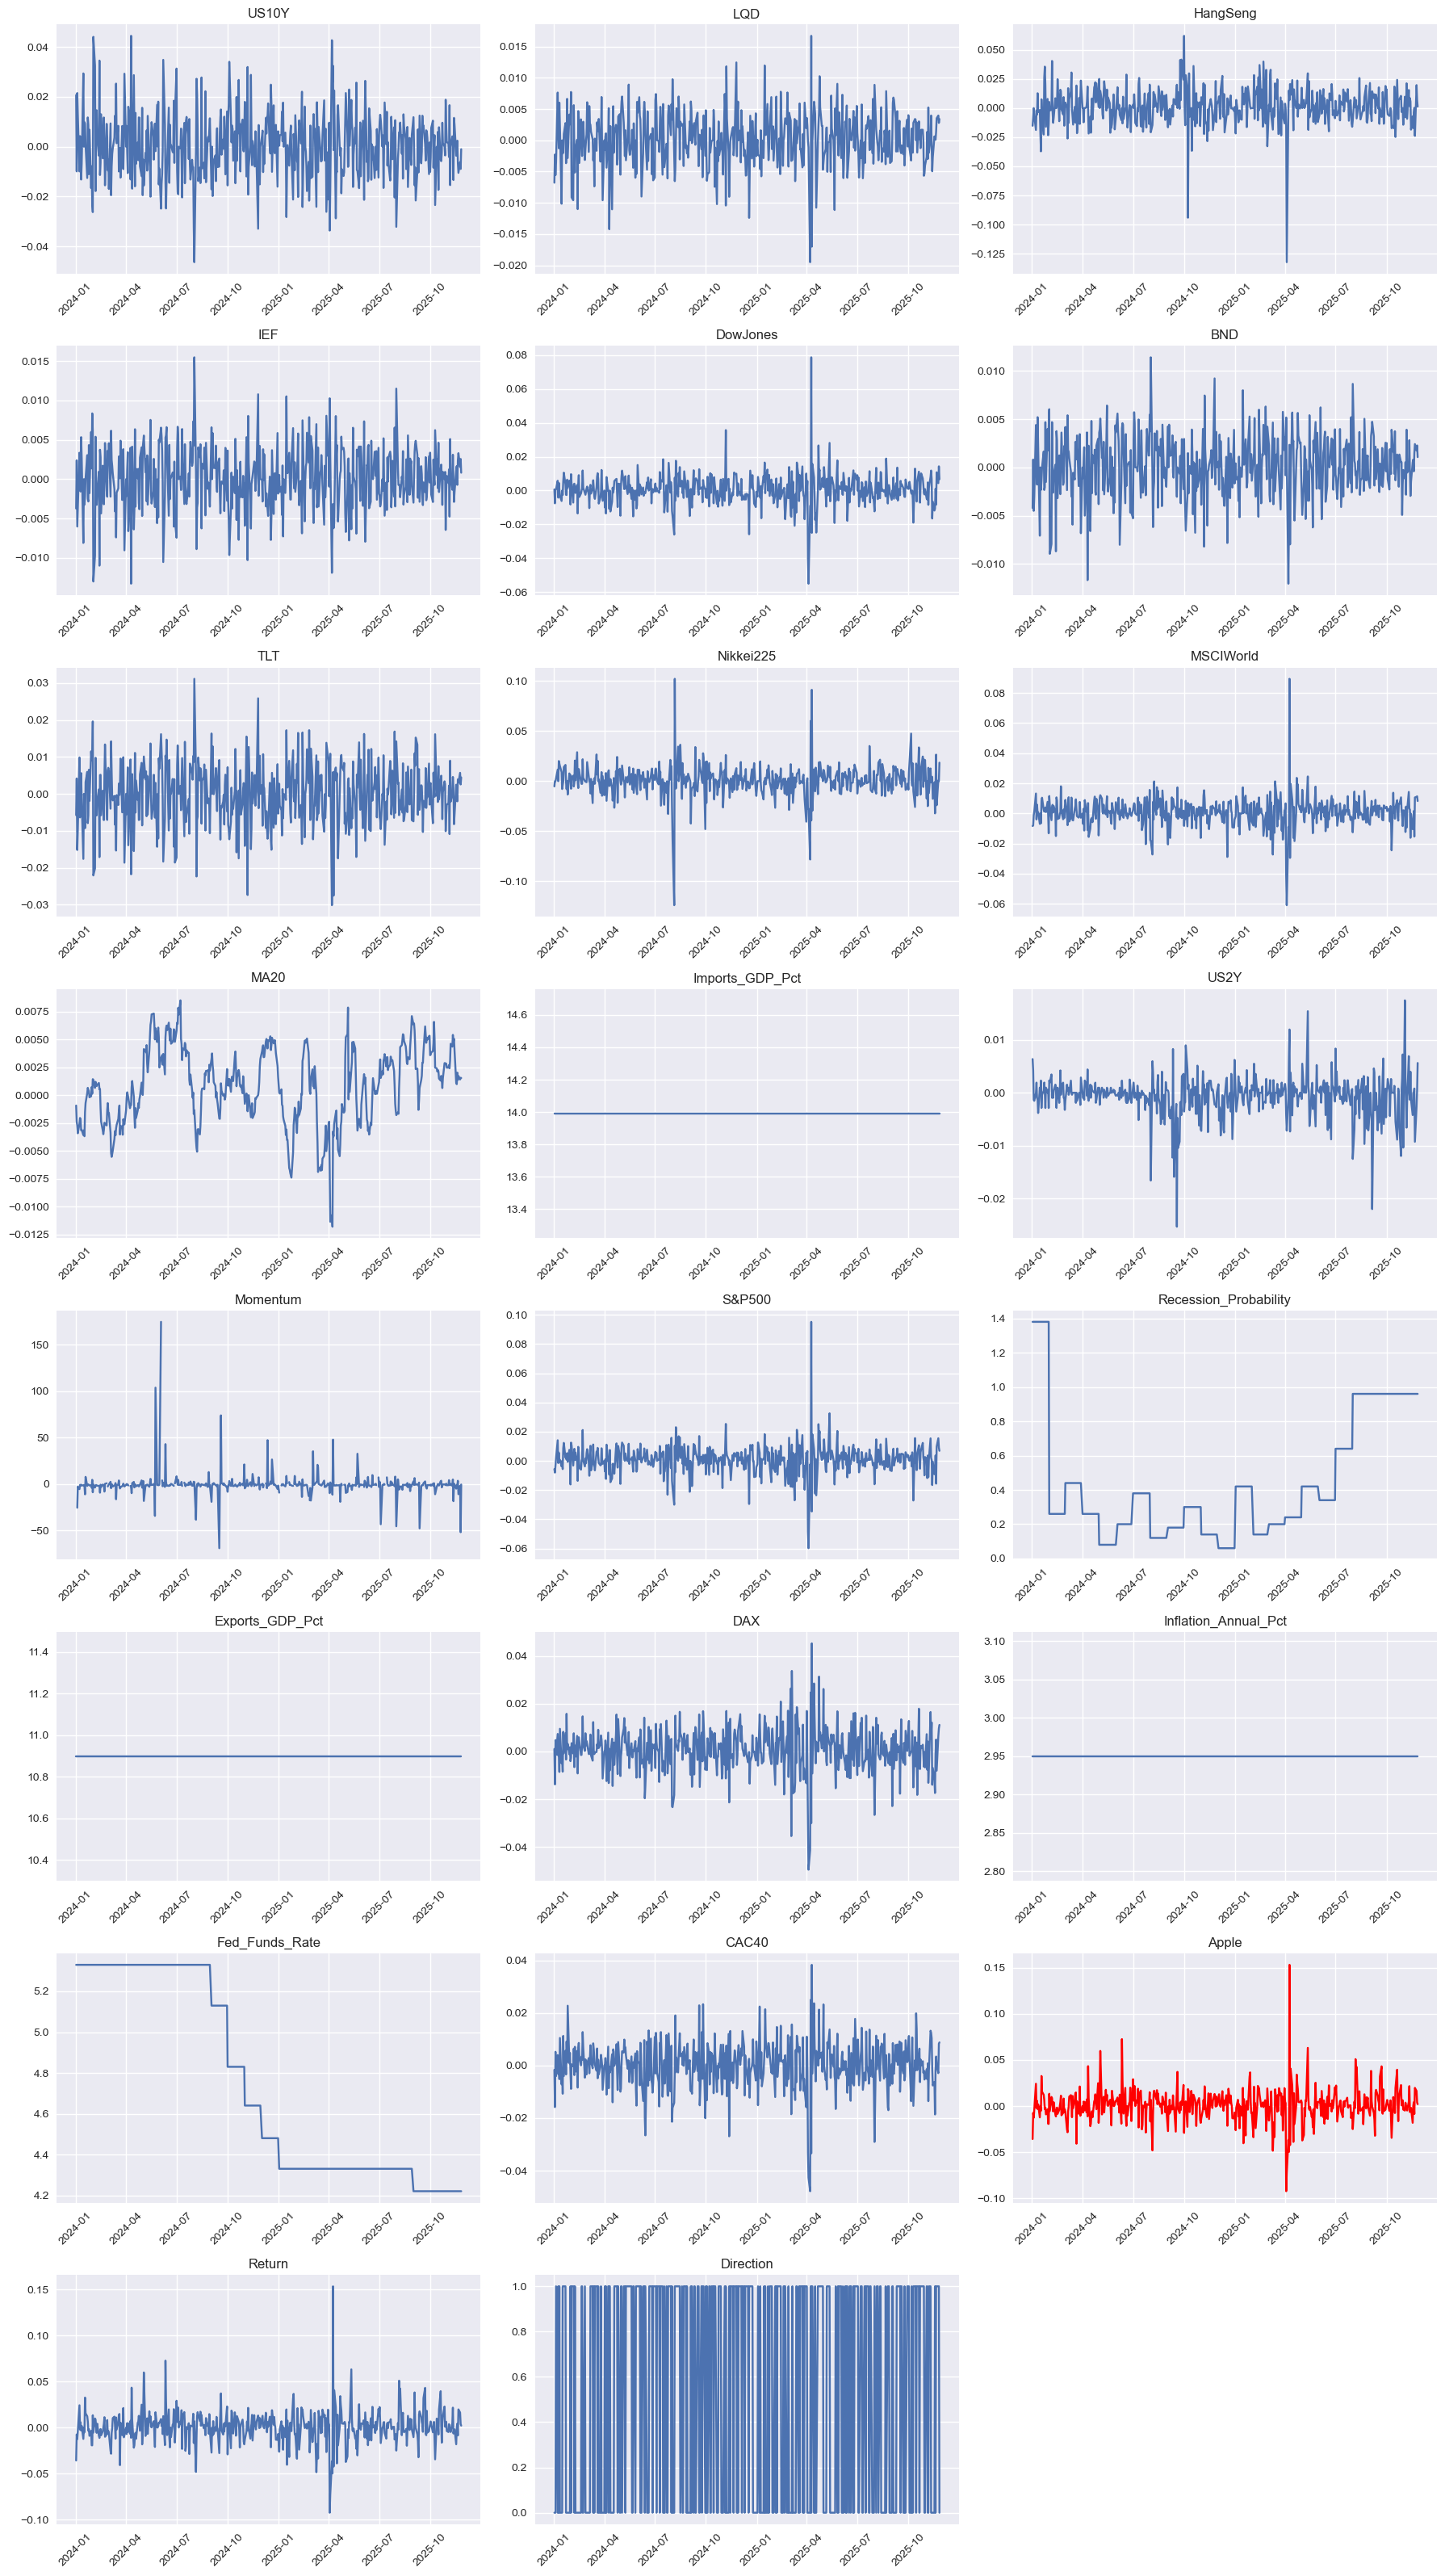

In [27]:
import matplotlib.pyplot as plt

# Filter the period
data_2024_2025 = data.loc['2024-01-01':'2025-12-31']

# Plot all columns as a grid of subplots
num_cols = len(data_2024_2025.columns)
n_rows = (num_cols // 3) + (num_cols % 3 > 0)  # 3 plots per row

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(data_2024_2025.columns):
    if col == 'Apple':
        axes[i].plot(data_2024_2025.index, data_2024_2025[col], color='red')
    else:
        axes[i].plot(data_2024_2025.index, data_2024_2025[col])

    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


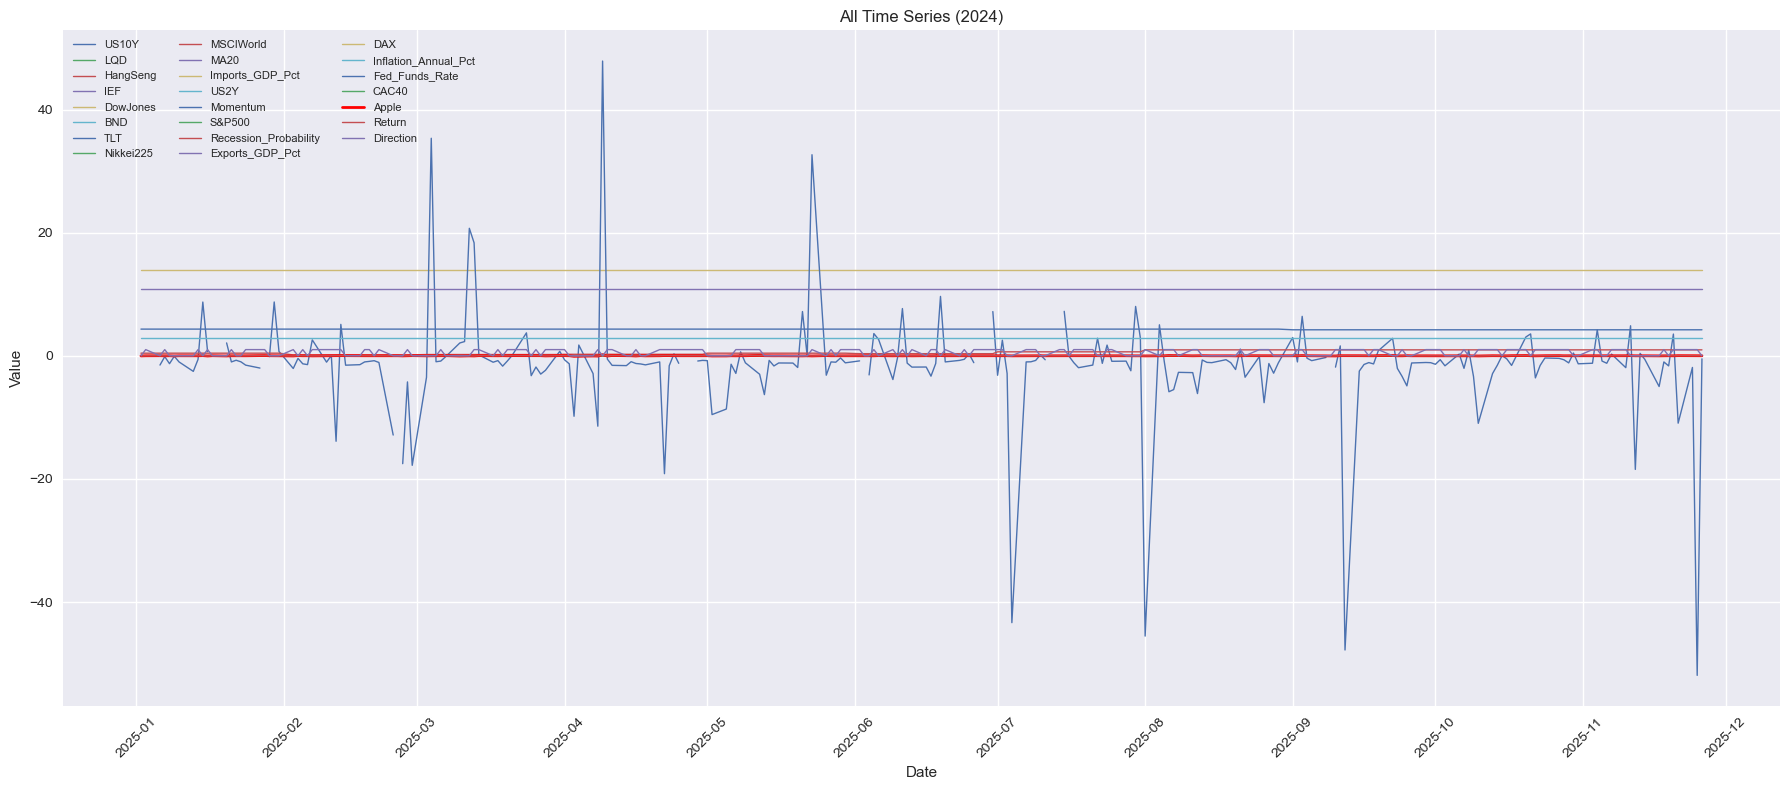

In [29]:
import matplotlib.pyplot as plt

# Restrict to year 2024 only
data_2024 = data.loc['2025-01-01':'2025-12-31']

plt.figure(figsize=(18, 8))

for col in data_2024.columns:
    if col == "Apple":
        plt.plot(data_2024.index, data_2024[col], label=col, linewidth=2, color='red')
    else:
        plt.plot(data_2024.index, data_2024[col], label=col, linewidth=1)

plt.title("All Time Series (2024)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(loc='upper left', fontsize=8, ncol=3)
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
